In [37]:
from IPython.core.debugger import set_trace

%load_ext nb_black


import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [38]:
csv_path = "/app/StockPricePredictions/data/alphavantage/time_series_daily_adjusted/AMZN/AMZN_WITH_BENZINGA_FINBERT_SA.csv"

<IPython.core.display.Javascript object>

In [39]:
df = pd.read_csv(csv_path)
df.sort_values(by=["date"], ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

date_time = pd.to_datetime(df.pop('date'))

df = df[["5. adjusted close"]].copy()

<IPython.core.display.Javascript object>

In [40]:
split_time = int(len(df) * .9)

train_df = df[:split_time]
test_df = df[split_time:]

print(len(train_df))
print(len(test_df))

df = test_df[["5. adjusted close"]].copy()

2757
307


<IPython.core.display.Javascript object>

In [41]:
df.describe()

,5. adjusted close
count,307.000000
mean,3302.874788
std,182.109845
min,2776.910000
25%,3190.135000
50%,3305.780000
75%,3421.470000
max,3731.410000


<IPython.core.display.Javascript object>

In [42]:
df.head()

,5. adjusted close
2757,3165.12
2758,3240.96
2759,3236.08
2760,3201.65
2761,3206.18


<IPython.core.display.Javascript object>

### Check if the time series is stationary

In [43]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["5. adjusted close"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -2.494893073271679
p-value: 0.11672184508120076


<IPython.core.display.Javascript object>

#### Autocorrelation Function (ACF)

In [44]:
from statsmodels.graphics.tsaplots import plot_acf

<IPython.core.display.Javascript object>

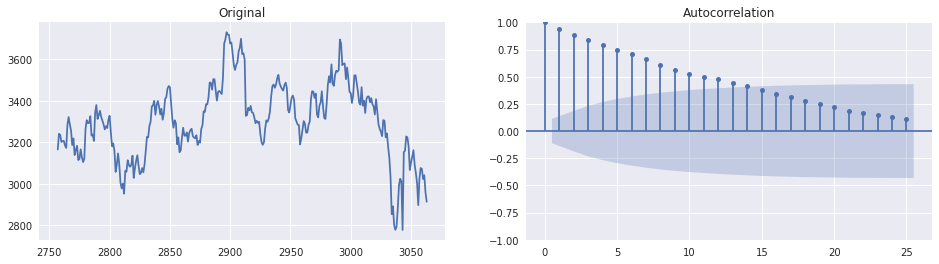

<IPython.core.display.Javascript object>

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(df["5. adjusted close"])
ax1.set_title("Original")
plot_acf(df["5. adjusted close"], ax=ax2);

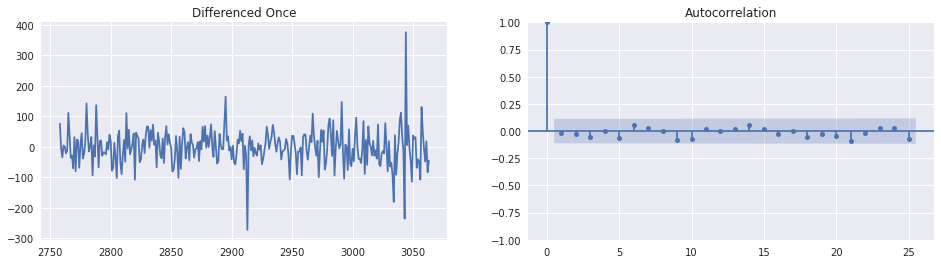

<IPython.core.display.Javascript object>

In [46]:
diff = df["5. adjusted close"].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Differenced Once")
plot_acf(diff, ax=ax2);

In [47]:
# pip install pmdarima
from pmdarima.arima.utils import ndiffs

<IPython.core.display.Javascript object>

In [48]:
ndiffs(df["5. adjusted close"])

1

<IPython.core.display.Javascript object>

__p__

p is the order of the Auto Regressive (AR) term.  It refers to the number of lags to be used as predictors.

We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial autocorrelation represents the correlation between the series and its lags.

In [49]:
from statsmodels.graphics.tsaplots import plot_pacf

<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


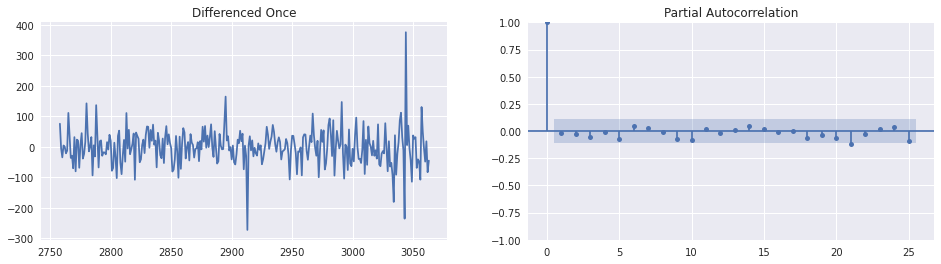

<IPython.core.display.Javascript object>

In [50]:
diff = df["5. adjusted close"].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Differenced Once")
plot_pacf(diff, ax=ax2);

__q__

q is the order of the Moving Average (MA) term.  It refers to the number of lagged forecast errors that should go into the ARIMA Model.

We can look at the ACF plot for the number of MA terms.



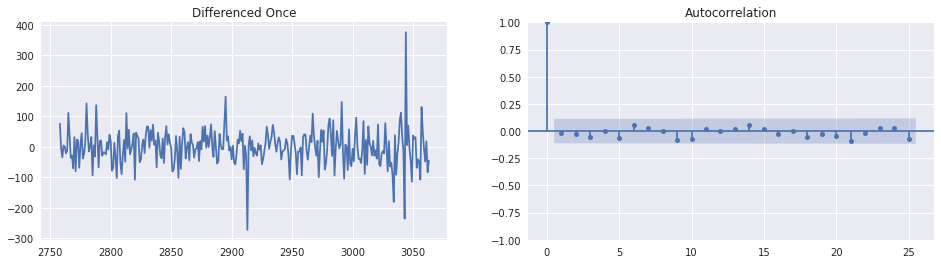

<IPython.core.display.Javascript object>

In [51]:
diff = df["5. adjusted close"].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Differenced Once")
plot_acf(diff, ax=ax2);

#### Fitting the ARIMA Model

In [52]:
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df["5. adjusted close"], order=(9,1,9))
result = model.fit()


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<IPython.core.display.Javascript object>

In [53]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      5. adjusted close   No. Observations:                  307
Model:                 ARIMA(9, 1, 9)   Log Likelihood               -1670.390
Date:                Sat, 09 Jul 2022   AIC                           3378.780
Time:                        04:59:59   BIC                           3449.528
Sample:                             0   HQIC                          3407.075
                                - 307                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3176      0.739      0.430      0.667      -1.131       1.766
ar.L2         -0.2086      0.381     -0.548      0.584      -0.955       0.538
ar.L3          0.2727      0.379      0.719      0.472      -0.470       1.016
ar.L4         -0.2889      0.391     -0.739      0.460      -1.055       0.477
ar.L5          0.1417      0.388      0.365      0.715      -0.619       0.902
ar.L6         -0.2147      0.384     -0.559      0.576      -0.968       0.538
ar.L7          0.0167      0.376      0.044      0.965      -0.721       0.754
ar.L8          0.6990      0.345      2.024      0.043       0.022       1.376
ar.L9         -0.0094      0.636     -0.015      0.988      -1.257       1.238
ma.L1         -0.3339      0.716     -0.466      0.641      -1.737       1.069
ma.L2          0.2176      0.423      0.515      0.607      -0.611       1.046
ma.L3         -0.3195      0.416     -0.768      0.443      -1.135       0.496
ma.L4          0.3020      0.473      0.639      0.523      -0.625       1.229
ma.L5         -0.2341      0.418     -0.560      0.575      -1.053       0.585
ma.L6          0.3173      0.414      0.767      0.443      -0.494       1.128
ma.L7         -0.0606      0.428     -0.142      0.887      -0.899       0.777
ma.L8         -0.7036      0.400     -1.758      0.079      -1.488       0.081
ma.L9         -0.1121      0.698     -0.160      0.873      -1.481       1.257
sigma2      3392.8463    587.270      5.777      0.000    2241.819    4543.873
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               527.00
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.33   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<IPython.core.display.Javascript object>

In [54]:
# Actual vs. Fitted

# result.plot_diagnostics()
len(result.forecasts[0])

307

<IPython.core.display.Javascript object>

In [55]:
df["preds"] = result.forecasts[0]

<IPython.core.display.Javascript object>

In [56]:
df.head()

,5. adjusted close,preds
2757,3165.12,0.000000
2758,3240.96,3165.137188
2759,3236.08,3241.035186
2760,3201.65,3235.364003
2761,3206.18,3198.438048


<IPython.core.display.Javascript object>

In [57]:
result.forecasts[0][-306:]

array([3165.13718834, 3241.03518611, 3235.36400296, 3198.43804829,
       3204.78735184, 3202.70863881, 3189.27711658, 3175.98888153,
       3283.95704301, 3316.72830533, 3279.57754118, 3256.89674492,
       3175.96187114, 3217.59765125, 3150.26347342, 3170.14078915,
       3183.58446828, 3096.99107755, 3125.81808263, 3164.15547474,
       3123.51187094, 3104.5036116 , 3128.52746305, 3275.46831608,
       3309.83440186, 3281.52789162, 3290.66570039, 3309.31618622,
       3232.74022307, 3242.40700257, 3209.77221666, 3341.65136895,
       3386.10438017, 3300.08640294, 3325.91762427, 3324.42905891,
       3326.86560959, 3320.9340428 , 3281.96324132, 3257.18212627,
       3277.67396216, 3273.03446736, 3304.63497319, 3300.73034049,
       3242.93782454, 3198.21684806, 3193.2060332 , 3163.9844804 ,
       3066.51465009, 3100.03114453, 3146.02182234, 3071.73101991,
       3002.92171937, 2990.91426553, 3001.89389309, 2968.59657438,
       3086.61174541, 3066.42792618, 3105.75339836, 3080.46931

<IPython.core.display.Javascript object>

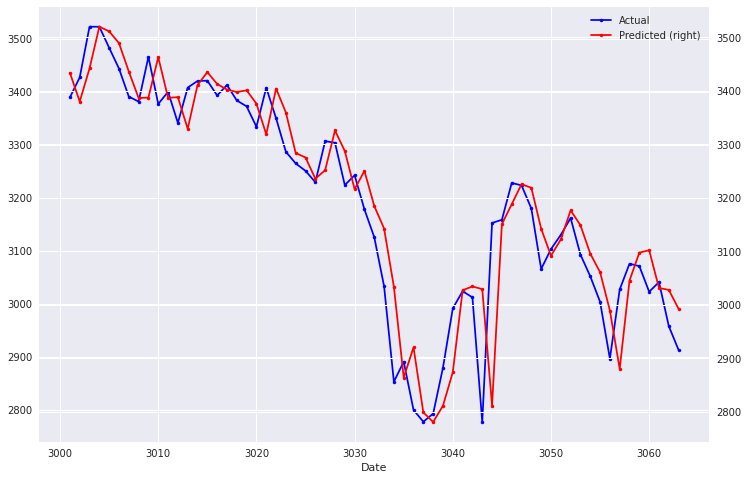

<IPython.core.display.Javascript object>

In [58]:
plt.figure(figsize=(12,8))

ax1 = df["5. adjusted close"][-63:].plot(color='blue', grid=True, secondary_y=False, label='Actual', marker='.')
ax2 = df["preds"][-63:].plot(color='red', grid=True, secondary_y=True, label='Predicted', marker='.')

# a, b = 275, 350

# ax1.set_ylim(a,b)
# ax2.set_ylim(a,b)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.set_xlabel("Date")
plt.legend(h1+h2, l1+l2, loc=1)
plt.show()

In [59]:
true = df["5. adjusted close"][-63:]
predicted = df["preds"][-63:]

def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))


print(mae(true, predicted))

55.084205107680205


<IPython.core.display.Javascript object>

In [60]:
df.tail()

,5. adjusted close,preds
3059,3071.26,3097.611251
3060,3022.84,3102.135843
3061,3041.05,3031.613736
3062,2957.97,3027.959676
3063,2912.82,2992.443833


<IPython.core.display.Javascript object>

In [61]:
df = df[-244:].copy()

true = df["5. adjusted close"][-244:]
predicted = df["preds"][-244:]

<IPython.core.display.Javascript object>

In [62]:
from sklearn.metrics import mean_absolute_error

<IPython.core.display.Javascript object>

In [63]:
test_mae = mean_absolute_error(true.to_numpy(), predicted)
f'Test MAE: {test_mae:.4f}'

'Test MAE: 40.7389'

<IPython.core.display.Javascript object>

In [64]:
df.tail(10)

,5. adjusted close,preds
3054,3052.03,3095.752852
3055,3003.95,3061.198370
3056,2896.54,2989.368675
3057,3027.16,2880.160426
3058,3075.77,3045.513051
3059,3071.26,3097.611251
3060,3022.84,3102.135843
3061,3041.05,3031.613736
3062,2957.97,3027.959676
3063,2912.82,2992.443833


<IPython.core.display.Javascript object>

In [65]:
df["actual_percentage_change"] = df['5. adjusted close'].pct_change()
df["actual_increase"] = df["actual_percentage_change"].apply(lambda x: 1 if x > 0 else 0)

<IPython.core.display.Javascript object>

In [66]:
df["predicted_percentage_change"] = df['preds'].pct_change()
df["predicted_increase"] = df["predicted_percentage_change"].apply(lambda x: 1 if x > 0 else 0)

<IPython.core.display.Javascript object>

In [67]:
df.head()

,5. adjusted close,preds,actual_percentage_change,actual_increase,predicted_percentage_change,predicted_increase
2820,3027.99,3128.922328,NaN,0,NaN,0
2821,3074.96,3044.674414,0.015512,1,-0.026926,0
2822,3110.87,3090.570872,0.011678,1,0.015074,1
2823,3137.50,3118.156370,0.008560,1,0.008926,1
2824,3087.07,3135.501205,-0.016073,0,0.005563,1


<IPython.core.display.Javascript object>

In [68]:
df.tail()

,5. adjusted close,preds,actual_percentage_change,actual_increase,predicted_percentage_change,predicted_increase
3059,3071.26,3097.611251,-0.001466,0,0.017107,1
3060,3022.84,3102.135843,-0.015766,0,0.001461,1
3061,3041.05,3031.613736,0.006024,1,-0.022733,0
3062,2957.97,3027.959676,-0.027320,0,-0.001205,0
3063,2912.82,2992.443833,-0.015264,0,-0.011729,0


<IPython.core.display.Javascript object>

In [69]:
df = df.drop(2820)

<IPython.core.display.Javascript object>

#### Postive Increase Prediction %

In [70]:
df[(df["actual_increase"]==1) & (df["predicted_increase"]==1)].shape[0] / df[(df["actual_increase"]==1)].shape[0]

0.6033057851239669

<IPython.core.display.Javascript object>

### Negative Increase Prediction %

In [71]:
df[(df["actual_increase"]==0) & (df["predicted_increase"]==0)].shape[0] / df[(df["actual_increase"]==0)].shape[0]

0.5901639344262295

<IPython.core.display.Javascript object>

#### Overall Prediction Accuracy %

In [72]:
df[(df["actual_increase"] == df["predicted_increase"])].shape[0] / (df.shape[0])

0.5967078189300411

<IPython.core.display.Javascript object>

#### Actual Distribution of Increase (1) vs. Decrease (0)

In [73]:
df["actual_increase"].value_counts(normalize=True)

0    0.502058
1    0.497942
Name: actual_increase, dtype: float64

<IPython.core.display.Javascript object>